In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import datetime

In [2]:
def dB(d):
    return 10*np.log10(d)
def lin(d):
    return 10**(d/10)

In [3]:
import dateutil
tz = dateutil.tz.gettz('Canada/Eastern')

In [4]:
fn = 'output0000.dat'
f = open(fn,'rb')

#header_fmt = "=iiiidiiiId" #format for struct package
header_fmt = np.dtype([('frame_length',  np.int32),
                       ('frame_header',  np.int32),
                       ('frame_samples', np.int32),
                       ('frame_dtype',   np.int32),
                       ('frame_raw_cad', np.float64),
                       ('frame_nfreq',   np.int32),
                       ('frame_nvis',    np.int32),
                       ('frame_int_len', np.int32),
                       ('frame_idx0',    np.uint32),
                       ('frame_utc0',    np.float64),
                      ])

header = np.fromfile(f,dtype=header_fmt,count=1)[0]
freqlist = np.fromfile(f,dtype=np.float32,count=2*header['frame_nfreq']).reshape(-1,2)
elemlist = np.fromfile(f,dtype=np.int8,count=header['frame_nvis'])

frame_fmt = np.dtype([('timestamp', np.float64),
                      ('data',      np.float32, 4*header['frame_nfreq'])])
dtmp = np.fromfile(f,dtype=frame_fmt)
dt = dtmp['data'].reshape(-1,4,header['frame_nfreq'])
data = {'timestamp':dtmp['timestamp'],
        'data':[dt[:,0,:], dt[:,1,:],dt[:,2,:]+1j*dt[:,3,:]]}
date = datetime.date.fromtimestamp(data['timestamp'][0])

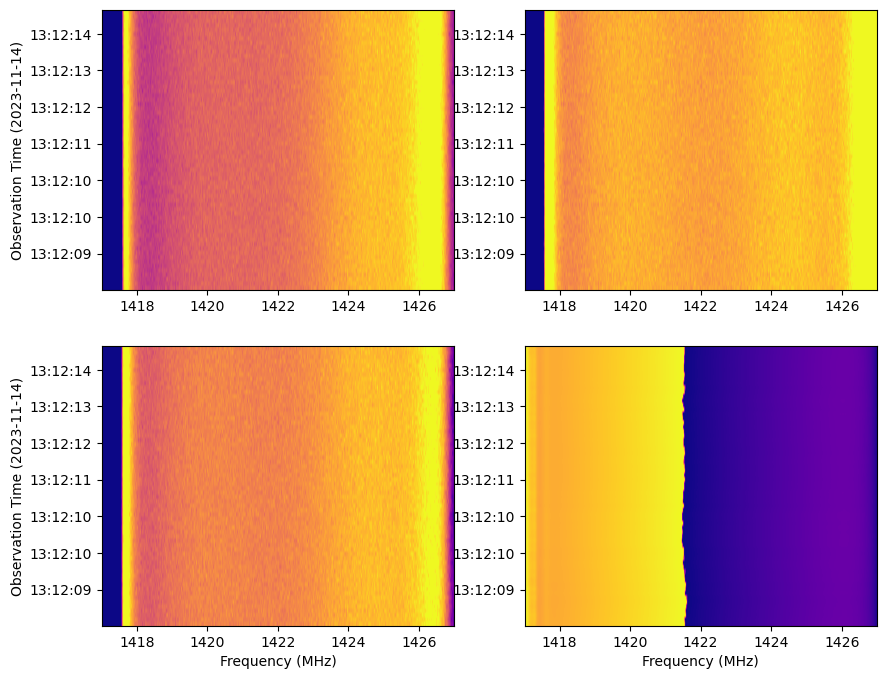

In [5]:
f,ax = plt.subplots(nrows=2,ncols=2,figsize=[10,8])

majorFormatter = mpl.dates.DateFormatter('%H:%M:%S',tz=tz)
ax[0][0].yaxis.set_major_formatter(majorFormatter)
ax[0][1].yaxis.set_major_formatter(majorFormatter)
ax[1][0].yaxis.set_major_formatter(majorFormatter)
ax[1][1].yaxis.set_major_formatter(majorFormatter)


ax[0][0].set_ylabel('Observation Time ({})'.format(date))
ax[1][0].set_ylabel('Observation Time ({})'.format(date))
ax[1][0].set_xlabel('Frequency (MHz)')
ax[1][1].set_xlabel('Frequency (MHz)')

ax[0][0].imshow(10*np.log10(data['data'][0]), aspect='auto',
          extent=[freqlist.mean(axis=1)[0]/1e6, freqlist.mean(axis=1)[-1]/1e6,
                  data['timestamp'][0]/86400., data['timestamp'][-1]/86400. ],
          vmin=18,vmax=21,cmap='plasma')

ax[0][1].imshow(10*np.log10(data['data'][1]), aspect='auto',
          extent=[freqlist.mean(axis=1)[0]/1e6, freqlist.mean(axis=1)[-1]/1e6,
                  data['timestamp'][0]/86400., data['timestamp'][-1]/86400. ],
          vmin=18,vmax=21,cmap='plasma')

ax[1][0].imshow(10*np.log10(np.abs(data['data'][2])), aspect='auto',
          extent=[freqlist.mean(axis=1)[0]/1e6, freqlist.mean(axis=1)[-1]/1e6,
                  data['timestamp'][0]/86400., data['timestamp'][-1]/86400. ],
          vmin=18,vmax=21,cmap='plasma')

ax[1][1].imshow(np.angle(data['data'][2]), aspect='auto',
          extent=[freqlist.mean(axis=1)[0]/1e6, freqlist.mean(axis=1)[-1]/1e6,
                  data['timestamp'][0]/86400., data['timestamp'][-1]/86400. ],
          vmin=-np.pi,vmax=np.pi,cmap='plasma')


Text(0.5, 0, 'Frequency (MHz)')

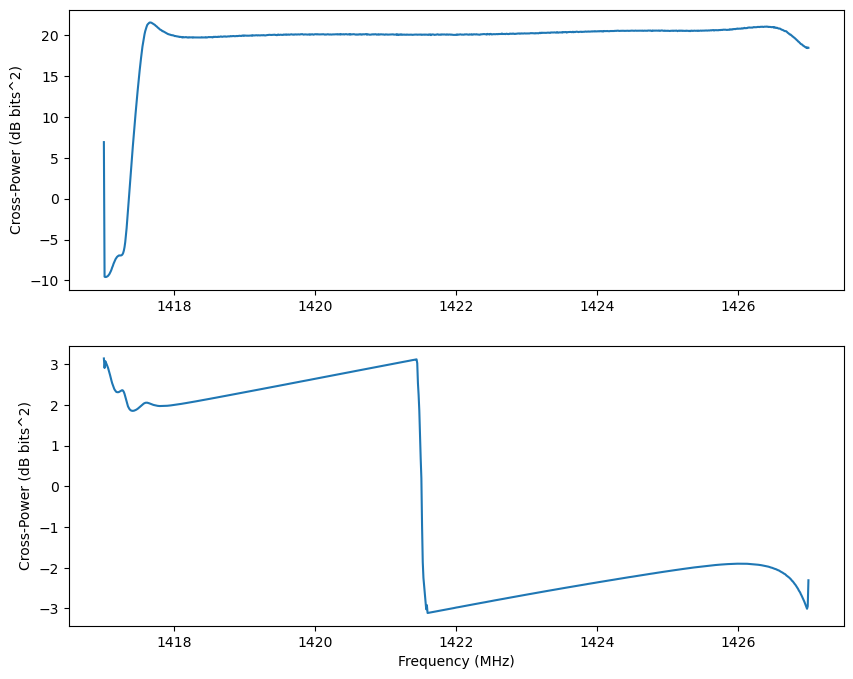

In [6]:
f,ax = plt.subplots(nrows=2,figsize=[10,8])
ax[0].plot(freqlist.mean(axis=1)/1e6,dB(np.abs(data['data'][2]).mean(axis=0)))
ax[0].set_ylabel('Cross-Power (dB bits^2)')
ax[1].plot(freqlist.mean(axis=1)/1e6,np.angle(data['data'][2]).mean(axis=0))
ax[1].set_ylabel('Cross-Power (dB bits^2)')
plt.xlabel('Frequency (MHz)')


Text(0, 0.5, 'Band-limited Phase (rad)')

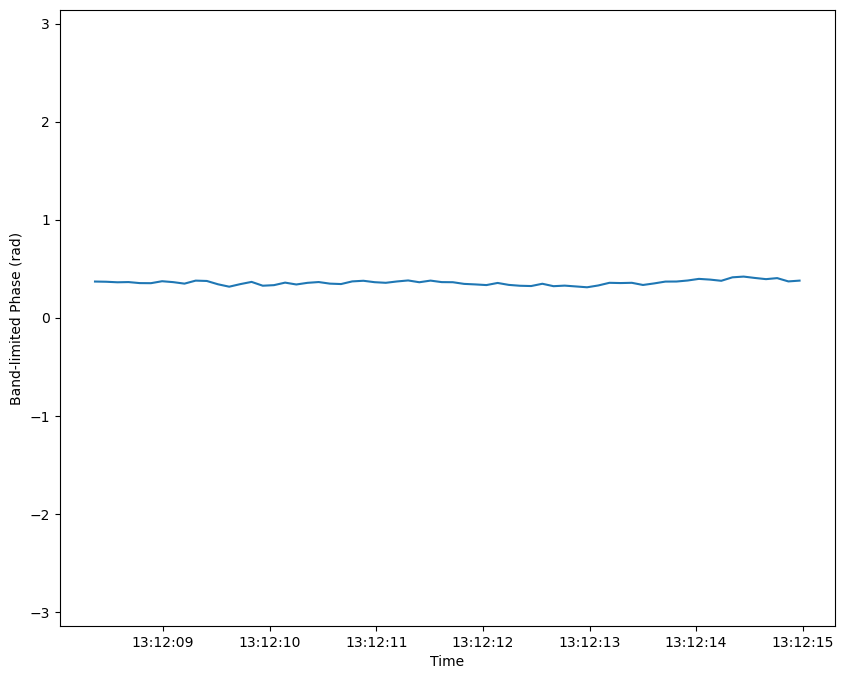

In [7]:
#pick out cross-phase between 1418 and 1424 MHz
q = np.where((freqlist[:,0] > 1418e6) * (freqlist[:,1] < 1424e6))[0]

f, ax = plt.subplots(figsize=[10,8])
plt.plot(data['timestamp']/86400.,np.angle(data['data'][2])[:,q].mean(axis=1))
plt.ylim(-np.pi,np.pi)
plt.xlabel('Time')
ax.xaxis_date(tz = 'Canada/Eastern')
plt.ylabel('Band-limited Phase (rad)')